In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data/test.csv
data/train.csv
data/sample_submission.csv


In [6]:
#Check the null values
df=pd.read_csv('data/train.csv')
df.isnull().sum()

id                          0
MO HLADR+ MFI (cells/ul)    1
Neu CD64+MFI (cells/ul)     1
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    1
label                       0
dtype: int64

In [7]:
#Fill the null with median
namelist=['MO HLADR+ MFI (cells/ul)','Neu CD64+MFI (cells/ul)','Mono CD64+MFI (cells/ul)']
for name in namelist:
    m=df[name].median()
    df[name]=df[name].fillna(m)

In [8]:
df.isnull().sum()

id                          0
MO HLADR+ MFI (cells/ul)    0
Neu CD64+MFI (cells/ul)     0
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    0
label                       0
dtype: int64

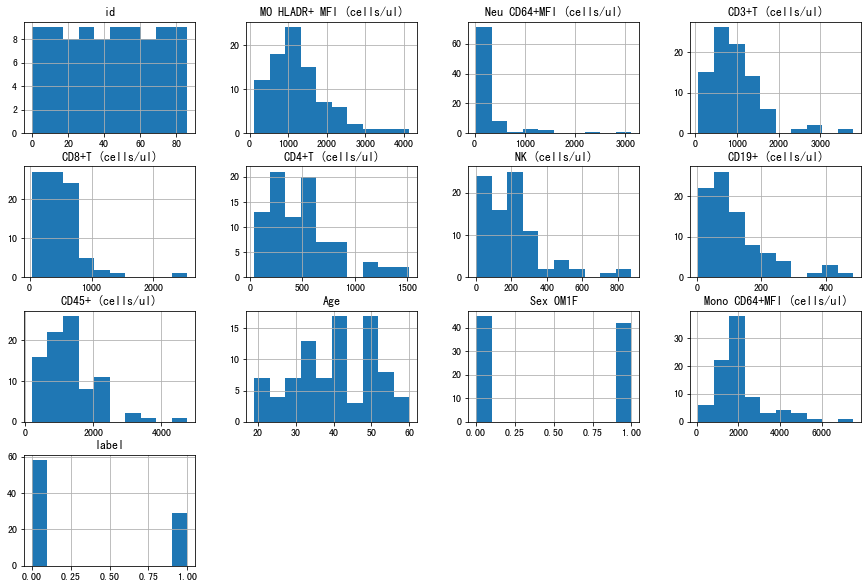

In [9]:
hist=df.hist(figsize=(15,10))

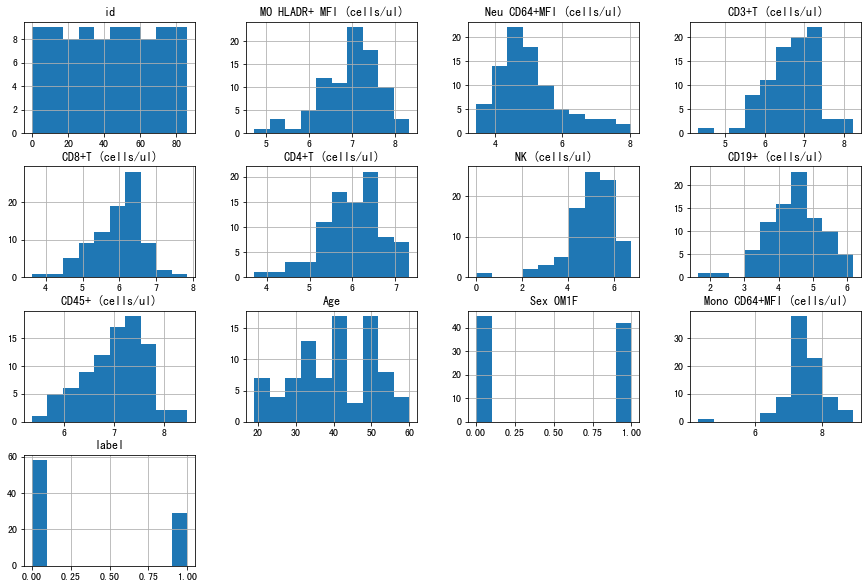

In [12]:
#plot the distribution after log transformation 
namelist=df.columns.tolist()
df_log=df.copy()

for name in ['id','label','Age','Sex 0M1F']:
    namelist.remove(name)

for name in namelist:
    df_log[name]=np.log1p(df[name])
    
hist=df_log.hist(figsize=(15,10))

In [17]:
# Extract Training and Validation Dataset
from sklearn.model_selection import train_test_split

df_train=df_log

X_train = df_train.drop(["label"], axis=1)
y_train = df_train["label"]

# Extract Testing Dataset
X_test =pd.read_csv('data/test.csv')


## Logistic Regression

In [18]:
#Logistic regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

logit = LogisticRegressionCV(max_iter=10000).fit(X_train,y_train)
y_pred = logit.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        58
           1       0.96      0.83      0.89        29

    accuracy                           0.93        87
   macro avg       0.94      0.91      0.92        87
weighted avg       0.93      0.93      0.93        87



## RandomForest

In [19]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        29

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



In [20]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
print(scores.mean())

0.8816363636363637


In [39]:
#use gridsearch to find best parameters
parameters={'n_estimators': [90,100,105,110,120,125,130,135,140]}
rdf=RandomForestClassifier()
clf=GridSearchCV(rdf,parameters,cv=5)
grid_result=clf.fit(X_train,y_train)
print("Best: %f using %s"%(grid_result.best_score_,clf.best_params_))


Best: 0.932026 using {'n_estimators': 130}


In [40]:
means=grid_result.cv_results_['mean_test_score']
params=grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f with:  %r"%(mean,param))
    

0.909150 with:  {'n_estimators': 90}
0.896732 with:  {'n_estimators': 100}
0.885621 with:  {'n_estimators': 105}
0.897386 with:  {'n_estimators': 110}
0.896732 with:  {'n_estimators': 120}
0.908497 with:  {'n_estimators': 125}
0.932026 with:  {'n_estimators': 130}
0.897386 with:  {'n_estimators': 135}
0.896732 with:  {'n_estimators': 140}


In [45]:
clf_rdf=RandomForestClassifier(max_depth=100, n_estimators=clf.best_params_["n_estimators"],
                               criterion= "gini",random_state=100)
clf_rdf.fit(X_train,y_train)
y_pred=clf_rdf.predict(X_train)

In [46]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        29

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



## Testing

In [48]:
for name in namelist:
    X_test[name]=np.log1p(X_test[name])

In [50]:
result=clf_rdf.predict(X_test)

In [51]:
result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [61]:
df_res=pd.DataFrame(columns=['label'])
df_res['label']=result

In [62]:
df_res.to_csv('submission.csv')